#Science Memes: Meme Template Recognition

In [ ]:
!pip install -q google-generativeai Pillow

In [ ]:
pip install google-search-results requests

  Preparing metadata (setup.py) ... done
  Created wheel for google-search-results: filename=google_search_results-2.4.2-py3-none-any.whl size=32010 sha256=b3de5f146d9ec1f5d453a242a334ec0b1f945cf9338b5cd899f769ba0fad7a73
  Stored in directory: /root/.cache/pip/wheels/6e/42/3e/aeb691b02cb7175ec70e2da04b5658d4739d2b41e5f73cd06f
Successfully built google-search-results


## necessary imports

In [ ]:
import os
import pandas as pd
import json
from tqdm.notebook import tqdm  # <--for notebook-friendly progress bar
from PIL import ImageChops, Image
import google.generativeai as genai
from collections import Counter
import re
import requests
from serpapi import GoogleSearch
from urllib.parse import quote_plus
from time import sleep

#---------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from PIL import UnidentifiedImageError

### mounting the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Creating a dataset to train the classifier

In [ ]:
#creating a clean dataset to train the classifier

# SerpAPI key
API_KEY = "YOUR_SERPAPI_KEY"

#  Meme templates to collect
meme_templates = [
    "4 panel comic meme",
    "drake meme templates",
    "buttons meme",
    "political compass meme",
    "wojak meme",
    "spongebob meme",
    "distracted boyfriend meme",
    "woman yelling at cat meme",
    "winnie the pooh meme",
    "expanding brain meme",
    "all doge meme templates",
    "the office meme",
    "roll safe meme",
    "family guy meme",
    "periodic table meme",
    "anime meme""
]

# 📁 Directory to save images
output_dir = "/your/dir/path"
os.makedirs(output_dir, exist_ok=True)

# 🖼 How many images to collect per template
images_per_template = 99

def download_images_for_template(template):
    print(f"\n🔍 Searching: {template}")
    label = template.replace(" ", "_").lower() #replace spaces
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    params = {
        "engine": "google",
        "q": template,
        "tbm": "isch", #this tells google to return image results
        "api_key": API_KEY,
        "ijn": 0.  #image results pagination index
    }

    search = GoogleSearch(params)
    results = search.get_dict()
    images = results.get("images_results", [])

    count = 0
    for i, img in enumerate(images):
        if count >= images_per_template:
            break
        img_url = img.get("original") or img.get("thumbnail") # thumbnail is a fallback if original image URL is not available
        if not img_url:
            continue

        try:
            response = requests.get(img_url, timeout=10) #download the image
            ext = img_url.split('.')[-1].split("?")[0] # try to guess extension
            filename = f"{label}_{i}.{ext}"
            filepath = os.path.join(label_dir, filename)

            with open(filepath, "wb") as f:
                f.write(response.content)

            print(f"✅ Downloaded {filename}")
            count += 1
            sleep(0.5)  # Be nice to the servers
        except Exception as e:
            print(f"⚠️ Failed to download image: {e}")

for template in meme_templates:
    download_images_for_template(template)
    sleep(2)  # Prevent rate-limiting

print("\n✅ All downloads complete.")



🔍 Searching: drake meme templates
✅ Downloaded drake_meme_templates_0.jpg
✅ Downloaded drake_meme_templates_1.jpg
✅ Downloaded drake_meme_templates_2.jpg
✅ Downloaded drake_meme_templates_3.webp
✅ Downloaded drake_meme_templates_4.jpg
✅ Downloaded drake_meme_templates_5.jpg
✅ Downloaded drake_meme_templates_6.jpg
✅ Downloaded drake_meme_templates_7.webp
⚠️ Failed to download image: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/topTemplateMemes/drake_meme_templates/drake_meme_templates_8.com/community/resource/df5cc507-a8cb-4858-90ba-04a5c3c83a0f/thumbnail'
✅ Downloaded drake_meme_templates_9.png
✅ Downloaded drake_meme_templates_10.jpg
✅ Downloaded drake_meme_templates_11.webp
✅ Downloaded drake_meme_templates_12.jpg
✅ Downloaded drake_meme_templates_13.jpg
✅ Downloaded drake_meme_templates_14.jpg
✅ Downloaded drake_meme_templates_15.jpg
✅ Downloaded drake_meme_templates_16.jpg
⚠️ Failed to download image: [Errno 2] No such fi

In [ ]:
#check if all the downloaded images are valid
def check_images_in_directory(root_dir):
    bad_files = []
    for class_folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, class_folder)
        if not os.path.isdir(folder_path):
            continue
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # check corruption
            except Exception as e:
                print(f"[Corrupt] {file_path}: {e}")
                bad_files.append(file_path)
    return bad_files

# Example usage:
bad_images = check_images_in_directory("/content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/topTemplateMemes")
print(f"🧹 Found {len(bad_images)} bad images.")


In [ ]:
#directories
image_dir = '/content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images'
meme_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/memes_df.csv')
cache_path = "/content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/cache.json" #containing the results from gemini

### defining some functions for later use

In [ ]:
def load_cache(cache_path):
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            cache = json.load(f)
        print(f"Loaded cache with {len(cache)} items.")
    else:
        cache = {}
        print("No cache found. Starting fresh.")
    return cache

def save_cache(cache, cache_path):
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    with open(cache_path, "w") as f:
        json.dump(cache, f)

In [ ]:
def count_missing_images(df, image_dir, verbose=True):
    """
    Counts how many images listed in the DataFrame (by post_id) are missing from the image directory.
    Returns the count and optionally prints the missing IDs.
    """
    missing = []
    for post_id in df['post_id']:
        found = False
        for ext in ['.jpg', '.png', '.jpeg', '.webp']:
            file_path = os.path.join(image_dir, f"{post_id}{ext}")
            if os.path.exists(file_path):
                found = True
                break
        if not found:
            missing.append(post_id)

    if verbose:
        print(f"\nMissing images: {len(missing)} out of {len(df)}")
        for post_id in missing:
            print(f" - {post_id}")

    return len(missing), missing

In [ ]:
#remove invalid images
for path in bad_images:
  os.remove(path)

# Supervised Classifier

### preparing the dataset for the model

In [ ]:
#preparing the dataset

# Define transforms
#train transform includes also data augmentation techniques
train_transform= transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(10),  # degrees
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # For RGB or 3-channel grayscale
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard size for most CNNs
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize to [-1, 1]
])



# Load dataset
dataset_path = "/your/dir/path"  # Update with your dataset path
train_data = datasets.ImageFolder(dataset_path, transform=train_transform)

# 80% train, 20% test
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, test_dataset = random_split(train_data, [train_size, test_size])
test_dataset.dataset.transform = val_transform # when doing this we are simply changing the transform that gets applied at access time

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Label mapping (e.g., 0 -> 'two_buttons')
class_names = train_data.classes

loading the chosen model - resnet18

In [ ]:
num_classes = len(class_names)  # from your dataset

# Load pretrained resnet18
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer to match your classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #CE because multiclass classification task
optimizer = optim.Adam(model.parameters(), lr=0.001)

## training loop

In [ ]:
#training the classifier
num_epochs = 5

for epoch in range(num_epochs):
  model.train()  # set model to training mode

  print(f"\nEpoch {epoch+1}/{num_epochs}")

  for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()           # clear previous gradients
      outputs = model(images)         # forward pass
      loss = criterion(outputs, labels)  # compute loss
      loss.backward()                 # backpropagate
      optimizer.step()                # update weights



Epoch 1/5

Epoch 2/5

Epoch 3/5

Epoch 4/5

Epoch 5/5


Trying to train also a second version of the model to which we feed images in the grayscale

In [ ]:
#preparing the dataset

# Define transforms
#train transform includes also data augmentation techniques
train_transform= transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomRotation(10),  # degrees
    # below to convert to grayscale
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # For RGB or 3-channel grayscale
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard size for most CNNs
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize to [-1, 1]
])



# Load dataset
dataset_path = "/content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/topTemplateMemes"
train_data = datasets.ImageFolder(dataset_path, transform=train_transform)

# 80% train, 20% test
train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, test_dataset = random_split(train_data, [train_size, test_size])
test_dataset.dataset.transform = val_transform # when doing this we are simply changing the transform that gets applied at access time

# Create DataLoader
train_loader_2 = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader_2 = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Load pretrained resnet18
model_2 = models.resnet18(pretrained=True)

# Replace the final fully connected layer to match your classes
model_2.fc = nn.Linear(model_2.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2 = model_2.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss() #CE because multiclass classification task
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [ ]:
#training the second version of the classifier
num_epochs = 5

for epoch in range(num_epochs):
  model_2.train()  # set model to training mode

  print(f"\nEpoch {epoch+1}/{num_epochs}")

  for images, labels in train_loader_2:
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()           # clear previous gradients
      outputs = model_2(images)         # forward pass
      loss = criterion(outputs, labels)  # compute loss
      loss.backward()                 # backpropagate
      optimizer.step()                # update weights


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 2/5

Epoch 3/5

Epoch 4/5

Epoch 5/5


## models evaluation

In [ ]:
def evaluate_model(model, test_loader, device):
    model.eval()  # set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients needed
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # get class with highest score
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy*100:.2f}%")
    return accuracy

In [ ]:
#evaluate_model on the train
evaluate_model(model, train_loader, device)

Accuracy: 97.63%


0.976271186440678

In [ ]:
#evaluate_model on the test
evaluate_model(model, test_loader, device)

Accuracy: 77.48%


0.7747747747747747

In [ ]:
##evaluate_model2 on the train
evaluate_model(model_2, train_loader_2, device)

Accuracy: 97.18%


0.9717514124293786

In [ ]:
##evaluate_model2 on the test
evaluate_model(model_2, test_loader_2, device)

Accuracy: 78.83%


0.7882882882882883

## Classifying the original dataset

In [ ]:
#utlisiing the trained classifier on the original dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard size for most CNNs
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalize to [-1, 1]
])


# Load image paths manually (since this is not class-labeled like ImageFolder)
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)
               if fname.lower().endswith(('.jpg', '.png', '.jpeg', '.webp'))]

### implementing a threshold

In [ ]:
def classify_with_threshold(model, image_path, threshold=0.7):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

        if confidence.item() >= threshold:
            return predicted_class.item(), confidence.item()
        else:
            return "noise", confidence.item()

In [ ]:
results_path = "/your/results/path.json"

In [ ]:
results = load_cache(results_path)

Loaded cache with 6329 items.


In [ ]:
for image_path in image_paths:
  image_id = os.path.basename(image_path)
  if image_id in results:
    continue
  try:
    label, conf = classify_with_threshold(model, image_path)

    if label == 'noise':
      label_name = 'noise'

    elif label!= 'noise':
      label_name = class_names[label]

    results[image_id] = {
          "template": label_name,
          "confidence": conf
      }
  except UnidentifiedImageError:
          results[image_id] = {
              "template": "image not found",
              "confidence": 0.0
          }
          print(f"Could not read image: {image_id}")

  except Exception as e:
      results[image_id] = {
          "template": "error",
          "confidence": 0.0
      }
      print(f"Error processing {image_id}: {e}")


storing the results

In [ ]:
#save the results in a json file for later use
with open(results_path, "w") as f:
    json.dump(results, f, indent=2)

removing the extension to match the ids in the df column 'post_id'

In [ ]:
def remove_extension(filename):
    return os.path.splitext(filename)[0]

results = {
    remove_extension(k): v for k, v in results.items()
}

# Gemini

In [ ]:
GOOGLE_API_KEY="YOUR_GOOGLE_API_KEY"

In [ ]:
genai.configure(api_key=GOOGLE_API_KEY)
gemini_model = genai.GenerativeModel('gemini-1.5-flash-latest')

### function that feeds the prompt and the image

In [ ]:
def identify_meme_template_gemini(image_path, post_id_for_filename):
    """
    Identifies the meme template name from an image using Gemini, using descriptive naming.
    """
    if not gemini_model:
        print("Gemini model not initialized. Cannot proceed.")
        return ""

    try:
        pil_image = Image.open(image_path)
        if pil_image.mode not in ('RGB', 'RGBA'):
            pil_image = pil_image.convert('RGB')

        #resize too large images
        MAX_SIDE = 1024
        if max(pil_image.size) > MAX_SIDE:
            pil_image.thumbnail((MAX_SIDE, MAX_SIDE), Image.Resampling.LANCZOS)

        # Crop borders
        from PIL import ImageChops
        def autocrop_image(pil_image, border_color=(255, 255, 255)):
            bg = Image.new(pil_image.mode, pil_image.size, border_color)
            diff = ImageChops.difference(pil_image, bg)
            bbox = diff.getbbox()
            return pil_image.crop(bbox) if bbox else pil_image

        pil_image = autocrop_image(pil_image)


        prompt = """
You are a meme classification expert.
Given an image of a meme, identify the visual meme template it uses and return a short name that uniquely and consistently describes it.
The name should:
- Be 2–5 words
- Refer to what is visually iconic or culturally recognizable
- Match common internet naming conventions if known (e.g., “drake meme”, “two buttons”, “surprised pikachu”)
- If the meme doesn't use a known template, describe the main visual layout or character (e.g., “man with whiteboard”, “knight with arrow”, “woman with math overlay”)
- If the image is only text (e.g., a screenshot, a tweet, or handwriting), return: **"text only"**
- If there is no identifiable meme template or structure, return: **"no template"**
Return only the template name. Do not explain or comment.
Always use lowercase.
"""

        response = gemini_model.generate_content([prompt, pil_image])
        raw_template_name = response.text.strip().lower()
        return raw_template_name

    except Exception as e:
        print(f"Error identifying meme in {image_path}: {e}")
        return "unknown"


In [ ]:

def classify_templates_for_dataframe(df, image_dir, cache_path="/path/to/cache.json", save_every=20):
    """
    Classifies meme templates and saves to a cache JSON file progressively.
    Skips memes already in the cache.
    """
    # Load existing cache if available - avoid useless computations
    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            template_names = json.load(f)
    else:
        template_names = {}

    count = 0
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Classifying memes"):
        post_id = row['post_id']

        if post_id in template_names:
            continue  # Skip already processed

        # Locate image
        found_file = None
        for ext in ['.jpg', '.png', '.jpeg', '.webp']:
            candidate_path = os.path.join(image_dir, f"{post_id}{ext}")
            if os.path.exists(candidate_path):
                found_file = candidate_path
                break

        if not found_file:
            template_names[post_id] = "image not found"
        else:
            try:
                template_name = identify_meme_template_gemini(found_file, post_id)
            except Exception as e:
                print(f"[Error] Failed to classify {post_id}: {e}")
                template_name = "error"
            template_names[post_id] = template_name

        count += 1

        # Save cache every `save_every` items
        if count % save_every == 0:
            with open(cache_path, 'w') as f:
                json.dump(template_names, f, indent=2)

    # Final save
    with open(cache_path, 'w') as f:
        json.dump(template_names, f, indent=2)

    print("✅ Finished. Total classified:", len(template_names))
    return template_names



### testing

In [ ]:
test_image_path = '/path/to/test/image.jpg'
test_id = "123test"
if not GOOGLE_API_KEY:
    print("*"*50)
    print("WARNING: GOOGLE_API_KEY environment variable is not set.")
    print("The Gemini OCR function will not work.")
    print("Please set it: export GOOGLE_API_KEY='your_api_key_here'")
    print("*"*50)
else:
  template_name = identify_meme_template_gemini(test_image_path, test_id)

  print(f"Predicted template name: '{template_name}'")

Predicted template name: 'smbc comics'


In [ ]:
template_names = load_cache(cache_path)

Loaded cache with 6411 items.


## classifying the whole dataset using gemini 1.5 flash

In [ ]:
template_names = classify_templates_for_dataframe(meme_df, image_dir)
print(template_names)

Classifying memes:   0%|          | 0/6411 [00:00<?, ?it/s]

Error identifying meme in /content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images/1ezkts6.jpg: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error identifying meme in /content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images/1f4yguo.jpg: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error identifying meme in /content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images/1fkxl2w.jpg: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Error identifying meme in /content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images/1ghym2g.jpg: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
Error identifying meme in /content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images/1gsi1k4.jpg: ('Connection

ERROR:tornado.access:500 POST /v1beta/models/gemini-1.5-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 2158.58ms


Error identifying meme in /content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images/1ktizs3.jpg: 500 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent?%24alt=json%3Benum-encoding%3Dint: TypeError: Load failed
Error identifying meme in /content/drive/MyDrive/Colab Notebooks/WebAndSocialNetworkAnalysis/sciencememes_images/1kwhvmn.jpg: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
✅ Finished. Total classified: 6411
{'4cqcjn': 'image not found', '5xs5zw': 'no template', '61f7gj': 'image not found', '61fd62': 'image not found', '62cggt': 'club penguin disconnect', '67h4kh': 'text only', '69e30r': 'text and image', '69y17i': 'image not found', '6foq8d': 'two clocks', '6gha21': 'spongebob and squidward', '6ijnh3': 'image not found', '6ikbdy': 'text only', '6ppfmv': 'man pointing at answer', '6s5uio': 'neil degrasse tyson laser eyes', '6sj2lz': 'text only', '6wlt4x': 'drakeposting',

In [ ]:
print(template_names['1l03ag6'])

woman observes artist on bus


## manually refining the output of the LLM

In [ ]:
# === unique labels ===
unique_templates = set(template_names.values())
print(f"\n🧾 Unique meme templates: {len(unique_templates)}")
print(unique_templates)

# === Most common memes ===
# Count only those that were matched
matched_templates = meme_df[meme_df["template_name"] != "not found"]["template_name"]
template_counts = Counter(matched_templates)

print("\n Most common meme templates:")
for template, count in template_counts.most_common(25):
    print(f"{template}: {count} memes")



🧾 Unique meme templates: 3067
{'spongebob burning', 'i think not', 'one does not simply walk into mordor', 'puppet men', 'troll face meme', 'yoda and luke', 'situation room', 'disturbed kid meme', 'bed and chairs', 'kowalski analysis', 'fat man with speech bubble', 'hitler collage', 'manga couple', 'family guy peter griffin', 'woman being choked by cat', 'parakeet arrows', 'angry hulk shrek meme', 'checklist meme', 'lab christmas tree', 'homer scorecard', 'confused hobbit', 'chad and soyjak', 'three-panel baby meme', 'goku pointing', "will smith it's time", 'bobby hill', 'office lady meme', 'two girls arguing', 'shelby from big bang theory', 'wise and brave knights', 'scientist inspecting beaker', 'uni and me', 'matthew mcconaughey "alright alright alright"', 'cow and explosion', 'bojo unimpressed', "gru's gun", 'wojak surprised', 'angry office guy', 'woman with cat head', 'scientist guy', 'hot dog man', 'francine screaming american dad', 'one punch man', 'simpsons presentation', 'pat

### creating label mappings

very similar labels need to be mapped to the same category, otherwise it seems like there are so much more different templates than there actually are

In [ ]:
#create label map
label_map = {
    "drakeposting": "drake meme",
    "drake format": "drake meme",
    "woman observes artist on bus": "comic",
    "feels guy": "wojak meme",
    "wojak surprised": "wojak meme",
    "woman explaining to wojak": "wojak meme",
    "wojak and girl": "wojak meme",
    "impact font meme": "meme with impact font",
    "collage": "image collage meme",
    "two buttons": "two buttons meme",
    "two button": "two buttons meme",
    "distracted bf": "distracted boyfriend",
    "galaxy brain": "expanding brain",
    "spongebob and patrick arguing": "spongebob and patrick",
    "patrick and spongebob": "spongebob and patrick",
    "four panel compass": "political compass meme",
}

In [ ]:
normalized_template_names = {
    post_id: label_map.get(label, label)
    for post_id, label in template_names.items()
}

In [ ]:
def normalize_label(label):
    label = label.lower()

    # Substring rules
    if "wojak" in label or "soyjak" in label:
        return "wojak meme"
    if "compass" in label or "political compass" in label or "four panels compass" in label:
        return "political compass meme"
    if "drake" in label or "drakeposting" in label or "drake template" in label:
        return "drake meme"
    if "two button" in label or "two buttons" in label or "button" in label:
        return "buttons meme"
    if "comic" in label:
        return "comic template meme"
    if "distracted bf" in label or "distracted boyfriend" in label:
        return "distracted boyfriend"
    if "spongebob" in label or "patrick" in label or "plankton" in label or "squidward" in label:
        return "spongebob meme"
    if "homer" in label or "bart" in label or "homer in bush" in label or "simpson" in label:
        return "simpsons meme"
    if "kowalski" in label or "penguins of madagascar" in label or "penguin" in label or "skipper" in label or "rico" in label:
        return "penguins meme"
    if "troll face" in label or "troll" in label:
        return "troll face meme"
    if "roll safe" in label or "roll safe meme" in label:
        return "roll safe meme"
    if "office" in label or "the office" in label or "michael scott" in label:
        return "the office meme"
    if "newton" in label:
        return "newton meme"
    if "einstein" in label:
        return "einstein meme"
    if "keanu" in label or "matrix" in label:
        return "matrix meme"
    if "incredibles" in label or "mister incredible" in label:
        return "incredibles meme"
    if "woman yelling at cat" in label or "woman yelling" in label:
        return "woman yelling at feline"
    if "cat" in label:
      return "cat concerning meme"
    if "family guy" in label or "peter griffin" in label or "griffin" in label or "lois" in label or "chris" in label or "meg griffin" in label:
        return "family guy meme"
    if "will smith" in label:
        return "will smith meme"
    if "scientist" in label:
        return "scientist involvoing meme"
    if "cow" in label:
        return "cow concerning meme"
    if "bojo" in label:
        return "bojo meme"
    if "winnie the pooh" in label:
        return "winnie the pooh meme"
    if "guy pointing" in label or "pointing" in label:
        return "pointing meme"
    if "clown" in label:
        return "clown meme"
    if "woman man" in label or "man woman" in label:
        return "woman man meme"
    if "harry potter" in label or "snape" in label or "hermione" in label or "Albus Dumbledore" in label or "Dumbledore" in label:
        return "harry potter meme"
    if "doggo" in label or "doge" in label:
        return "doge meme"
    if "periodic table" in label:
        return "periodic table meme"
    if "genie" in label:
        return "genie meme"
    if "collage" in label:
        return "image collage meme"
    if "anime" in label or "manga" in label:
        return "anime meme"
    if "breaking bad" in label:
        return "breaking bad meme"
    if "trump" in label:
        return "trump meme"
    if "scooby" in label or "shaggy" in label or "velma" in label:
        return "scooby doo meme"
    if "monster inc" in label or "wazowski" in label or "sullivan" in label:
        return "monster inc meme"
    if "brain" in label:
        return "brain meme"
    if "bill gates" in label:
        return "bill gates meme"
    if "big bang theory" in label or "sheldon" in label:
        return "big bang theory meme"
    if "rick and morty" in label:
        return "rick and morty meme"
    if "thanos" in label:
        return "thanos meme"
    if "google search" in label:
        return "google search meme"
    if "attack on titan" in label:
        return "attack on titan meme"
    if "speech bubble" in label:
        return "speech bubble involving meme"
    if "science fair" in label or "science project"in label:
        return "science project/fair meme"
    if "starwars" in label or "yoda" in label:
        return "star wars meme"
    if "lord of the rings" in label or "mordor" in label or "sauron" in label or "hobbit" in label:
        return "lord of the rings meme"
    if "toy story" in label or "woody" in label:
        return "toy story meme"
    if "two images" in label:
        return "two images meme"
    if "dio" in label or "god" in label:
        return "god meme"
    if "eminem" in label:
        return "eminem meme"
    if "dicaprio" in label:
        return "leonardo dicaprio meme"
    if "before and after" in label or "before/after" in label:
        return "before/after meme"
    if "musk" in label:
        return "elon musk meme"
    if "checmical" in label or "element" in label or "chemistry" in label or "molecule" in label:
        return "chemistry meme"
    if "stick figure" in label or "stickman" in label:
        return "stick figures meme"
    if "lego" in label:
        return "lego meme"
    if "door" in label:
        return "doors meme"
    if "iron man" in label or "ironman" in label or "robert downey jr" in label:
        return "iron man meme"
    if "spider man" in label or "spiderman" in label or "venom" in label:
        return "spider man meme"
    if "dog" in label:
        return "dogs concerning meme"
    if "perry the platipus" in label or "doofenshmirtz" in label or "ferb" in label or "phineas" in label or "candace" in label:
        return "phineas and ferb meme"
    if "tom and jerry" in label:
        return "tom and jerry meme"
    if "expectation vs. reality" in label:
        return "expectation vs. reality meme"
    if "amazon" in label:
        return "amazon meme"
    if "jack sparrow" in label:
        return "jack sparrow meme"
    if "avengers" in label or "hulk" in label or "thor" in label or "captain america" in label:
        return "avengers meme"
    if "earth" in label:
        return "earth concerning meme"
    if "math" in label:
        return "math concerning meme"
    if "gru" in label or "despicable me" in label:
        return "despicable meme"

    # Add more as needed

    return label.strip()  # fallback to original


In [ ]:
template_names = {
    post_id: normalize_label(label)
    for post_id, label in normalized_template_names.items()
}

In [ ]:
with open(cache_path, 'w') as f:
  json.dump(template_names, f, indent=2)

we can see from the output of the following cell that the number of unique templates has been drastically reduced - even though the refining could go even further

In [ ]:
# ===  Sanity check for matching post_ids ===
meme_df["template_name"] = meme_df["post_id"].apply(
    lambda pid: template_names.get(str(pid), "not found")
)

# === Get all unique labels ===
unique_templates = set(template_names.values())
print(f"\n🧾 Unique meme templates: {len(unique_templates)}")
print(unique_templates)

# === Most common memes ===
# Count only those that were matched
matched_templates = meme_df[meme_df["template_name"] != "not found"]["template_name"]
template_counts = Counter(matched_templates)

print("\n Most common meme templates:")
for template, count in template_counts.most_common(30):
    print(f"{template}: {count} memes")



🧾 Unique meme templates: 2177
{'i think not', 'puppet men', 'troll face meme', 'situation room', 'disturbed kid meme', 'bed and chairs', 'parakeet arrows', 'checklist meme', 'three-panel baby meme', 'bobby hill', 'two girls arguing', 'uni and me', 'wise and brave knights', 'matthew mcconaughey "alright alright alright"', 'francine screaming american dad', 'one punch man', 'blindfolded woman and man', 'two girls one cup', 'funny words magic man', 'four glasses', 'i love science man', 'disgusted/pleased flower', 'geralt of rivia', 'homelander stare', 'man walking through text', 'confused guy', 'drake meme', 'phase diagram', 'superman and batman', 'trade offer meme', 'kitten on scale', 'simple instruction panels', 'corporate needs you to find the differences', 'smiley face', 'blue text box meme', 'yugioh meme', 'surprised guy', 'sad frog', 'fred reveals the ghost', 'woman crying with money', 'the exorcist movie poster', 'science project/fair meme', 'multiple choice chart', 'graduation ha

In [ ]:
target_template = "two muscular men shaking hands"

matching_post_ids = [post_id for post_id, template in normalized_template_names.items() if template == target_template]

print(matching_post_ids)

['1jqfy9i']


In [ ]:
#save updated dataframe
meme_df.to_csv("/path/to/meme/df.csv", index=False)

### Creating the final dataframe

we combine the results from the first section with the results from this section

In [ ]:
final_df = pd.read_csv('/path/to/final_df.csv')

In [ ]:
meme_df_with_templates =pd.read_csv('/path/to/meme_df_with_templates.csv')

In [ ]:
#composing the final dataset
meme_df_with_templates["template"] =meme_df_with_templates["post_id"].apply(
    lambda pid: results.get(str(pid), {}).get("template", "error")
)

meme_df_with_templates["classifier_confidence"] =meme_df_with_templates["post_id"].apply(
    lambda pid: results.get(str(pid), {}).get("confidence", 0)
)


In [ ]:
#complete with gemini
def remove_noise(pid, label):
    if label != "noise" and label != 'periodic_table_meme':
        return label
    else:
        return template_names.get(str(pid), "no template")

meme_df_with_templates["template"] = meme_df_with_templates.apply(
    lambda row: remove_noise(
        row["post_id"],
        row["template"]
    ),
    axis=1
)


In [ ]:
meme_df_with_templates

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,post_id,subreddit,author,title,selftext,url,created_utc,score,num_comments,link_flair_text,template_name,template,classifier_confidence
0,0,0,0,4cqcjn,conspiracymemes,mmp,The Climate is Changing!,NaN,http://i.imgur.com/AvrISa3.jpg,2016-03-31 16:53:11,21,7,NaN,image not found,error,0.000000
1,1,1,1,5xs5zw,dankmemes,Megazone_,Scientists have discovered a new form of cancer,NaN,https://i.redd.it/dof67ry0zqjy.jpg,2017-03-06 09:22:14,4137,54,NaN,no template,no template,0.524423
2,2,2,2,61f7gj,dankmemes,frenzy3,Vax or not to Vax,NaN,http://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:02:52,37392,302,NaN,image not found,error,0.000000
3,3,3,3,61fd62,memes,BraveReddit,Vax or not to Vax,NaN,https://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:48:29,7721,95,NaN,image not found,error,0.000000
4,4,4,4,62cggt,dankmemes,brand198,Rip Clu🅱️ Penguin (2005-2017) 😭😭😭,NaN,https://i.redd.it/ft2ca6wiwhoy.jpg,2017-03-30 09:12:04,19599,203,NaN,penguins meme,penguins meme,0.407330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,6406,6406,6406,1kzwagk,memes,Evethefief,Third day of 30+ °C just hit,NaN,https://i.redd.it/vsyhdpfz544f1.png,2025-05-31 14:47:42,1,4,NaN,image not found,error,0.000000
6407,6407,6407,6407,1kzxm2f,physicsmemes,Awesomeuser90,Reading by the Light of the Aurora? Not For Me...,NaN,https://i.redd.it/7gld3mx4g44f1.png,2025-05-31 15:52:09,48,6,NaN,bad luck brian,bad luck brian,0.532210
6408,6408,6408,6408,1l00uwz,chemistrymemes,Bouamamamoh,"📚 Get ""Electrochemical Methods: Fundamentals a...",Hey everyone! I have a special offer where you...,https://i.redd.it/281jy17u654f1.png,2025-05-31 18:14:18,0,0,NaN,amazon meme,amazon meme,0.962900
6409,6409,6409,6409,1l039yt,politicalcompassmemes,Severe-Breath3028,My version of left.,My 4 things:\n\n1. Every human has a right to ...,https://i.redd.it/6ukd9me7p54f1.jpeg,2025-05-31 19:57:04,0,10,Agenda Post,political compass meme,political compass meme,0.785435


In [ ]:
meme_df_with_templates.drop(columns = ['template_name'])

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,post_id,subreddit,author,title,selftext,url,created_utc,score,num_comments,link_flair_text,template,classifier_confidence
0,0,0,0,4cqcjn,conspiracymemes,mmp,The Climate is Changing!,NaN,http://i.imgur.com/AvrISa3.jpg,2016-03-31 16:53:11,21,7,NaN,error,0.000000
1,1,1,1,5xs5zw,dankmemes,Megazone_,Scientists have discovered a new form of cancer,NaN,https://i.redd.it/dof67ry0zqjy.jpg,2017-03-06 09:22:14,4137,54,NaN,no template,0.524423
2,2,2,2,61f7gj,dankmemes,frenzy3,Vax or not to Vax,NaN,http://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:02:52,37392,302,NaN,error,0.000000
3,3,3,3,61fd62,memes,BraveReddit,Vax or not to Vax,NaN,https://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:48:29,7721,95,NaN,error,0.000000
4,4,4,4,62cggt,dankmemes,brand198,Rip Clu🅱️ Penguin (2005-2017) 😭😭😭,NaN,https://i.redd.it/ft2ca6wiwhoy.jpg,2017-03-30 09:12:04,19599,203,NaN,penguins meme,0.407330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,6406,6406,6406,1kzwagk,memes,Evethefief,Third day of 30+ °C just hit,NaN,https://i.redd.it/vsyhdpfz544f1.png,2025-05-31 14:47:42,1,4,NaN,error,0.000000
6407,6407,6407,6407,1kzxm2f,physicsmemes,Awesomeuser90,Reading by the Light of the Aurora? Not For Me...,NaN,https://i.redd.it/7gld3mx4g44f1.png,2025-05-31 15:52:09,48,6,NaN,bad luck brian,0.532210
6408,6408,6408,6408,1l00uwz,chemistrymemes,Bouamamamoh,"📚 Get ""Electrochemical Methods: Fundamentals a...",Hey everyone! I have a special offer where you...,https://i.redd.it/281jy17u654f1.png,2025-05-31 18:14:18,0,0,NaN,amazon meme,0.962900
6409,6409,6409,6409,1l039yt,politicalcompassmemes,Severe-Breath3028,My version of left.,My 4 things:\n\n1. Every human has a right to ...,https://i.redd.it/6ukd9me7p54f1.jpeg,2025-05-31 19:57:04,0,10,Agenda Post,political compass meme,0.785435


In [ ]:
meme_df_with_templates.to_csv('/path/to/meme_df_with_templates.csv')

In [ ]:
final_df

,post_id,subreddit,author,title,selftext,url,created_utc,score,num_comments,link_flair_text,...,CLS_emotion_love,CLS_emotion_nervousness,CLS_emotion_optimism,CLS_emotion_pride,CLS_emotion_realization,CLS_emotion_relief,CLS_emotion_remorse,CLS_emotion_sadness,CLS_emotion_surprise,CLS_emotion_sarcasm_score
0,4cqcjn,conspiracymemes,mmp,The Climate is Changing!,NaN,http://i.imgur.com/AvrISa3.jpg,2016-03-31 16:53:11,21,7,NaN,...,0.000174,0.0,0.0,0.0,0.0,0.0,0.0,0.998228,0.000171,0.009910
1,5xs5zw,dankmemes,Megazone_,Scientists have discovered a new form of cancer,NaN,https://i.redd.it/dof67ry0zqjy.jpg,2017-03-06 09:22:14,4137,54,NaN,...,0.003839,0.0,0.0,0.0,0.0,0.0,0.0,0.026510,0.012437,0.979880
2,61f7gj,dankmemes,frenzy3,Vax or not to Vax,NaN,http://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:02:52,37392,302,NaN,...,0.002716,0.0,0.0,0.0,0.0,0.0,0.0,0.026353,0.001932,0.138070
3,61fd62,memes,BraveReddit,Vax or not to Vax,NaN,https://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:48:29,7721,95,NaN,...,0.002716,0.0,0.0,0.0,0.0,0.0,0.0,0.026353,0.001932,0.138070
4,62cggt,dankmemes,brand198,Rip Clu🅱️ Penguin (2005-2017) 😭😭😭,NaN,https://i.redd.it/ft2ca6wiwhoy.jpg,2017-03-30 09:12:04,19599,203,NaN,...,0.001157,0.0,0.0,0.0,0.0,0.0,0.0,0.943693,0.001008,0.984628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,1kzwagk,memes,Evethefief,Third day of 30+ °C just hit,NaN,https://i.redd.it/vsyhdpfz544f1.png,2025-05-31 14:47:42,1,4,NaN,...,0.002066,0.0,0.0,0.0,0.0,0.0,0.0,0.034875,0.012067,0.925595
6407,1kzxm2f,physicsmemes,Awesomeuser90,Reading by the Light of the Aurora? Not For Me...,NaN,https://i.redd.it/7gld3mx4g44f1.png,2025-05-31 15:52:09,48,6,NaN,...,0.007607,0.0,0.0,0.0,0.0,0.0,0.0,0.067529,0.005477,0.991596
6408,1l00uwz,chemistrymemes,Bouamamamoh,"📚 Get ""Electrochemical Methods: Fundamentals a...",Hey everyone! I have a special offer where you...,https://i.redd.it/281jy17u654f1.png,2025-05-31 18:14:18,0,0,NaN,...,0.001486,0.0,0.0,0.0,0.0,0.0,0.0,0.002338,0.086727,0.996021
6409,1l039yt,politicalcompassmemes,Severe-Breath3028,My version of left.,My 4 things:\n\n1. Every human has a right to ...,https://i.redd.it/6ukd9me7p54f1.jpeg,2025-05-31 19:57:04,0,10,Agenda Post,...,0.000529,0.0,0.0,0.0,0.0,0.0,0.0,0.000697,0.000353,0.996712


In [ ]:
final_df = final_df.merge(
    meme_df_with_templates[["post_id", "template", "classifier_confidence"]],
    on="post_id",
    how="left"
)

In [ ]:
final_df

,post_id,subreddit,author,title,selftext,url,created_utc,score,num_comments,link_flair_text,...,CLS_emotion_optimism,CLS_emotion_pride,CLS_emotion_realization,CLS_emotion_relief,CLS_emotion_remorse,CLS_emotion_sadness,CLS_emotion_surprise,CLS_emotion_sarcasm_score,template,classifier_confidence
0,4cqcjn,conspiracymemes,mmp,The Climate is Changing!,NaN,http://i.imgur.com/AvrISa3.jpg,2016-03-31 16:53:11,21,7,NaN,...,0.0,0.0,0.0,0.0,0.0,0.998228,0.000171,0.009910,error,0.000000
1,5xs5zw,dankmemes,Megazone_,Scientists have discovered a new form of cancer,NaN,https://i.redd.it/dof67ry0zqjy.jpg,2017-03-06 09:22:14,4137,54,NaN,...,0.0,0.0,0.0,0.0,0.0,0.026510,0.012437,0.979880,no template,0.524423
2,61f7gj,dankmemes,frenzy3,Vax or not to Vax,NaN,http://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:02:52,37392,302,NaN,...,0.0,0.0,0.0,0.0,0.0,0.026353,0.001932,0.138070,error,0.000000
3,61fd62,memes,BraveReddit,Vax or not to Vax,NaN,https://i.imgur.com/CyGgLlF.jpg,2017-03-25 13:48:29,7721,95,NaN,...,0.0,0.0,0.0,0.0,0.0,0.026353,0.001932,0.138070,error,0.000000
4,62cggt,dankmemes,brand198,Rip Clu🅱️ Penguin (2005-2017) 😭😭😭,NaN,https://i.redd.it/ft2ca6wiwhoy.jpg,2017-03-30 09:12:04,19599,203,NaN,...,0.0,0.0,0.0,0.0,0.0,0.943693,0.001008,0.984628,penguins meme,0.407330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6406,1kzwagk,memes,Evethefief,Third day of 30+ °C just hit,NaN,https://i.redd.it/vsyhdpfz544f1.png,2025-05-31 14:47:42,1,4,NaN,...,0.0,0.0,0.0,0.0,0.0,0.034875,0.012067,0.925595,error,0.000000
6407,1kzxm2f,physicsmemes,Awesomeuser90,Reading by the Light of the Aurora? Not For Me...,NaN,https://i.redd.it/7gld3mx4g44f1.png,2025-05-31 15:52:09,48,6,NaN,...,0.0,0.0,0.0,0.0,0.0,0.067529,0.005477,0.991596,bad luck brian,0.532210
6408,1l00uwz,chemistrymemes,Bouamamamoh,"📚 Get ""Electrochemical Methods: Fundamentals a...",Hey everyone! I have a special offer where you...,https://i.redd.it/281jy17u654f1.png,2025-05-31 18:14:18,0,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.002338,0.086727,0.996021,amazon meme,0.962900
6409,1l039yt,politicalcompassmemes,Severe-Breath3028,My version of left.,My 4 things:\n\n1. Every human has a right to ...,https://i.redd.it/6ukd9me7p54f1.jpeg,2025-05-31 19:57:04,0,10,Agenda Post,...,0.0,0.0,0.0,0.0,0.0,0.000697,0.000353,0.996712,political compass meme,0.785435


In [ ]:
final_df.to_csv('/path/to/final_meme_df.csv')

In [ ]:
final_meme_df = pd.read_csv('/path/to/final_meme_df.csv')

## Analises and visualisation

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


### most frequently used templates

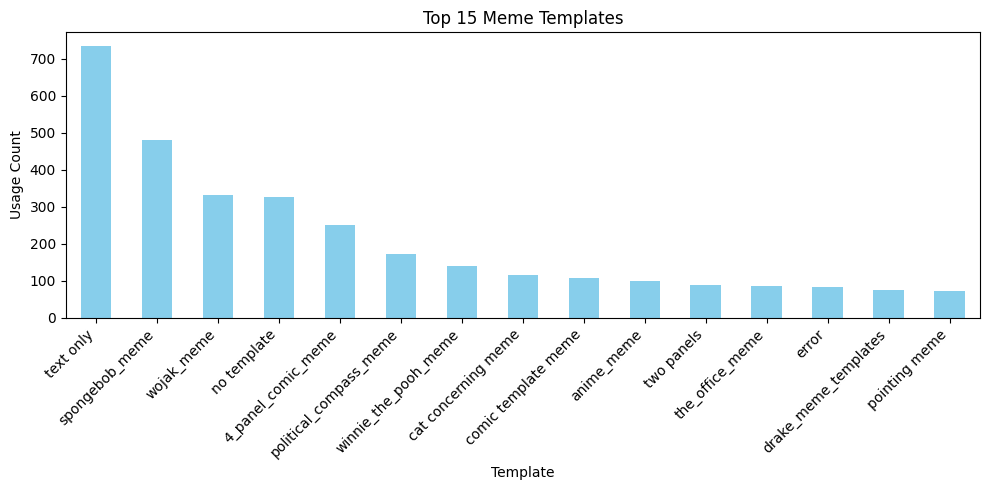

In [ ]:
#most used templates
top_templates = final_meme_df["template"].value_counts().head(15)

top_templates.plot(kind="bar", figsize=(10, 5), color="skyblue")
plt.title("Top 15 Meme Templates")
plt.xlabel("Template")
plt.ylabel("Usage Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### template usage by label

In [ ]:
#template usage by final label
template_usage = final_meme_df.groupby(["final_label", "template"]).size().unstack(fill_value=0)

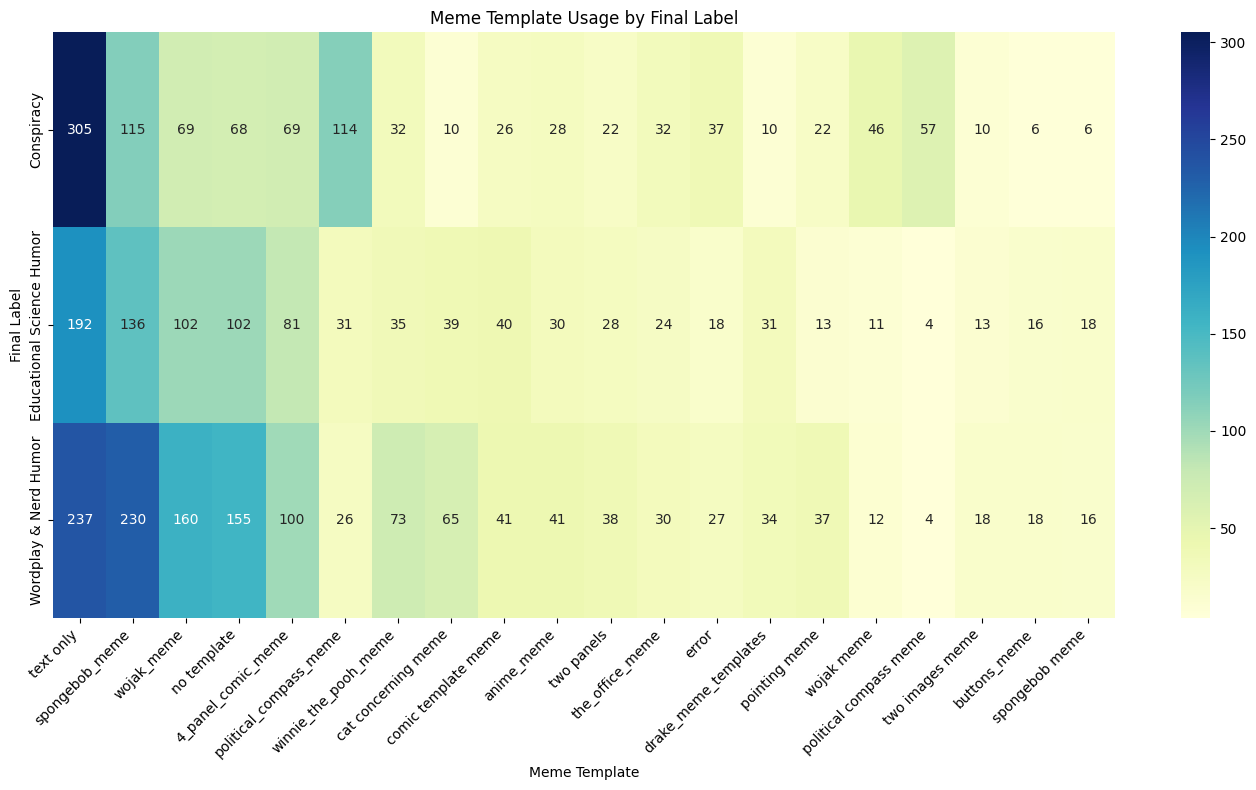

In [ ]:
# Increase figure size for clarity
plt.figure(figsize=(14, 8))

# Show top N templates only (optional to avoid clutter)
top_templates = final_meme_df["template"].value_counts().head(20).index
filtered_usage = template_usage[top_templates]

# Heatmap
sns.heatmap(filtered_usage, annot=True, fmt="d", cmap="YlGnBu", cbar=True)
plt.title("Meme Template Usage by Final Label")
plt.xlabel("Meme Template")
plt.ylabel("Final Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### top templates per label

In [ ]:
#top templates per label
top_templates = final_meme_df.groupby("final_label")["template"].value_counts().groupby(level=0).head(5)
print(top_templates)

final_label                template              
Conspiracy                 text only                 305
                           spongebob_meme            115
                           political_compass_meme    114
                           4_panel_comic_meme         69
                           wojak_meme                 69
Educational Science Humor  text only                 192
                           spongebob_meme            136
                           no template               102
                           wojak_meme                102
                           4_panel_comic_meme         81
Wordplay & Nerd Humor      text only                 237
                           spongebob_meme            230
                           wojak_meme                160
                           no template               155
                           4_panel_comic_meme        100
Name: count, dtype: int64


<ipython-input-28-3397bc11d4a5>:22: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


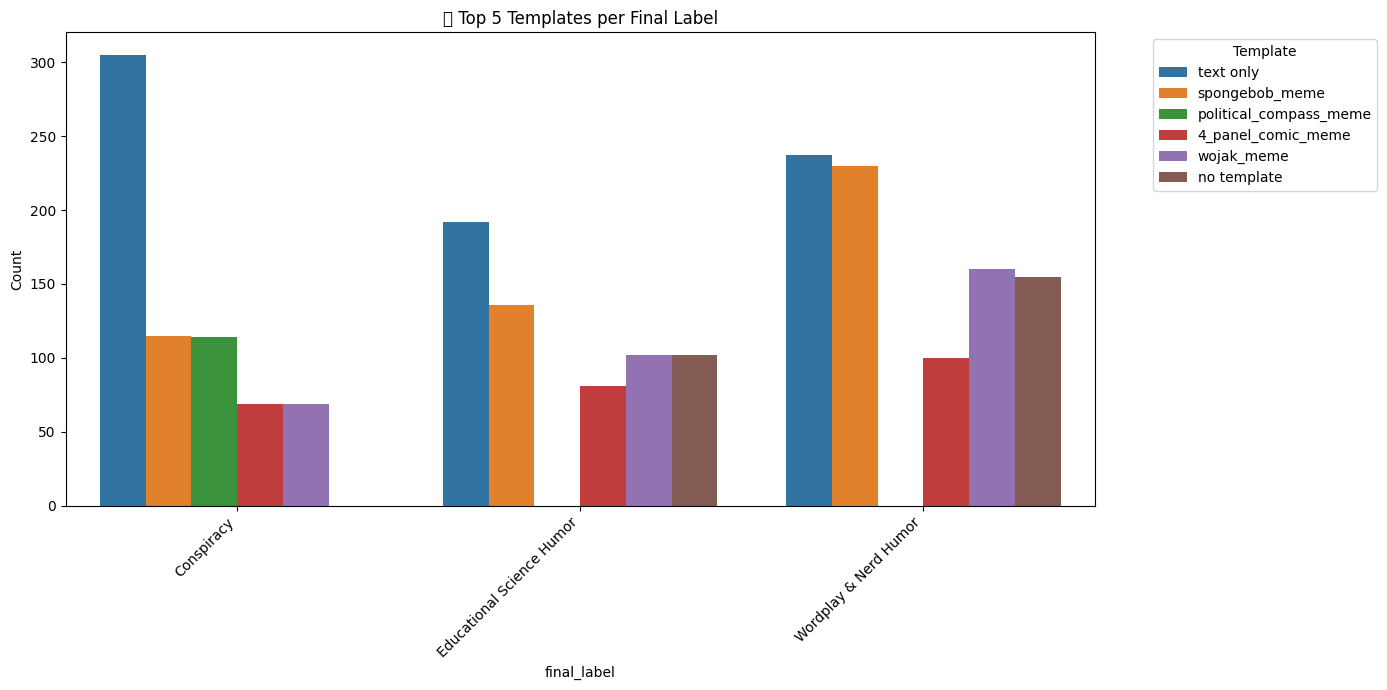

In [ ]:
# Prepare data
template_counts = (
    final_meme_df.groupby(["final_label", "template"])
    .size()
    .reset_index(name="count")
)

# Filter top 5 templates per label
top_per_label = (
    template_counts.sort_values(["final_label", "count"], ascending=[True, False])
    .groupby("final_label")
    .head(5)
)

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=top_per_label, x="final_label", y="count", hue="template")
plt.title("🎯 Top 5 Templates per Final Label")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.legend(title="Template", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### template diversity per label

<ipython-input-29-76c5d0351d16>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=template_diversity.values, y=template_diversity.index, palette="viridis")


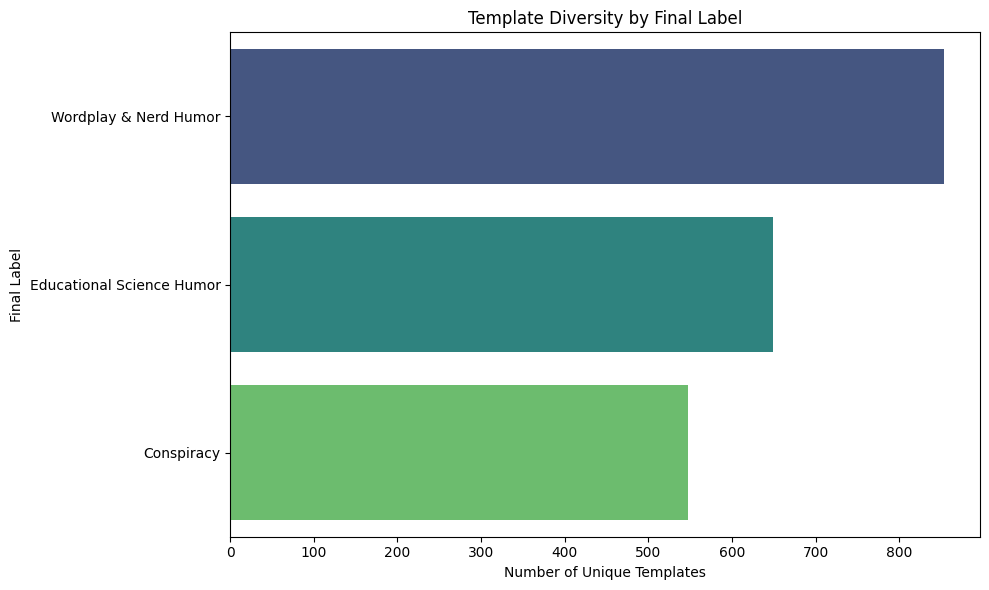

In [ ]:
#Template Diversity by Label - Measures how visually repetitive or diverse memes are in a category.
template_diversity = final_df.groupby("final_label")["template"].nunique().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=template_diversity.values, y=template_diversity.index, palette="viridis")
plt.title("Template Diversity by Final Label")
plt.xlabel("Number of Unique Templates")
plt.ylabel("Final Label")
plt.tight_layout()
plt.show()

### Chi-Squared test

In [ ]:
# Chi-Squared Test for Independence - statistically tests whether certain templates are associated with certain labels more than expected by chance.
from scipy.stats import chi2_contingency

contingency = pd.crosstab(final_meme_df["template"], final_meme_df["final_label"])
chi2, p, dof, ex = chi2_contingency(contingency)
print(f"Chi2 = {chi2:.2f}, p = {p:.4f}")


Chi2 = 4143.70, p = 0.0000
